In [42]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os

In [43]:
data_path = Path("data")
image_path = data_path / "CIFAR10"
train_data = torchvision.datasets.CIFAR10(root=image_path,
                                         train=True,
                                         download=True,
                                         transform=transforms.ToTensor())
test_data = torchvision.datasets.CIFAR10(root=image_path,
                                         train=False,
                                         download=True,
                                        transform=transforms.ToTensor())
print(train_data, test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data\CIFAR10
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data\CIFAR10
    Split: Test
    StandardTransform
Transform: ToTensor()


In [44]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)
print(train_dataloader, test_dataloader)
print(f"Train dataloader lenght: {len(train_dataloader)}\nTest dataloader lenght: {len(test_dataloader)}")

<torch.utils.data.dataloader.DataLoader object at 0x000002225382BFD0> <torch.utils.data.dataloader.DataLoader object at 0x0000022242902050>
Train dataloader lenght: 1563
Test dataloader lenght: 313


In [45]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape

torch.Size([32, 3, 32, 32])

In [46]:
train_data.classes, image_batch.dtype

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 torch.float32)

In [47]:
class TinyVGG(nn.Module):
    def __init__(self, input_size: int, hidden_units: int, output_size: int):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(nn.Conv2d(in_channels=input_size,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=0,
                                                    stride=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=0,
                                                    stride=1),
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size=2,
                                                       stride=1))
        self.conv_layer_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=0,
                                                    stride=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=0,
                                                    stride=1),
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size=2,
                                                       stride=1))
        self.linear_layer = nn.Sequential(nn.Flatten(),
                                          nn.Linear(in_features=hidden_units*22*22,
                                                    out_features=output_size))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.linear_layer(x)
        return x

In [61]:
model1 = TinyVGG(input_size = 3, hidden_units = 10, output_size = len(train_data.classes))
model1

TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4840, out_features=10, bias=True)
  )
)

In [62]:
def random_predictions():
    fig = plt.figure(figsize=(10,10))
    rows, cols = 3,3
    for i in range(1,rows*cols+1):
        rand_int = torch.randint(0,len(test_data),size=[1]).item()
        rand_img, rand_lbl = test_data[rand_int]
        y_pred = model1(rand_img.unsqueeze(dim=0)).argmax(dim=1)
        pred_class = test_data.classes[y_pred]
        rand_class = test_data.classes[rand_lbl]
        fig.add_subplot(rows,cols,i)
        plt.imshow(rand_img.permute(1,2,0))
        plt.title(f"Pred: {pred_class}, Actual: {rand_class}")
        plt.axis(False)

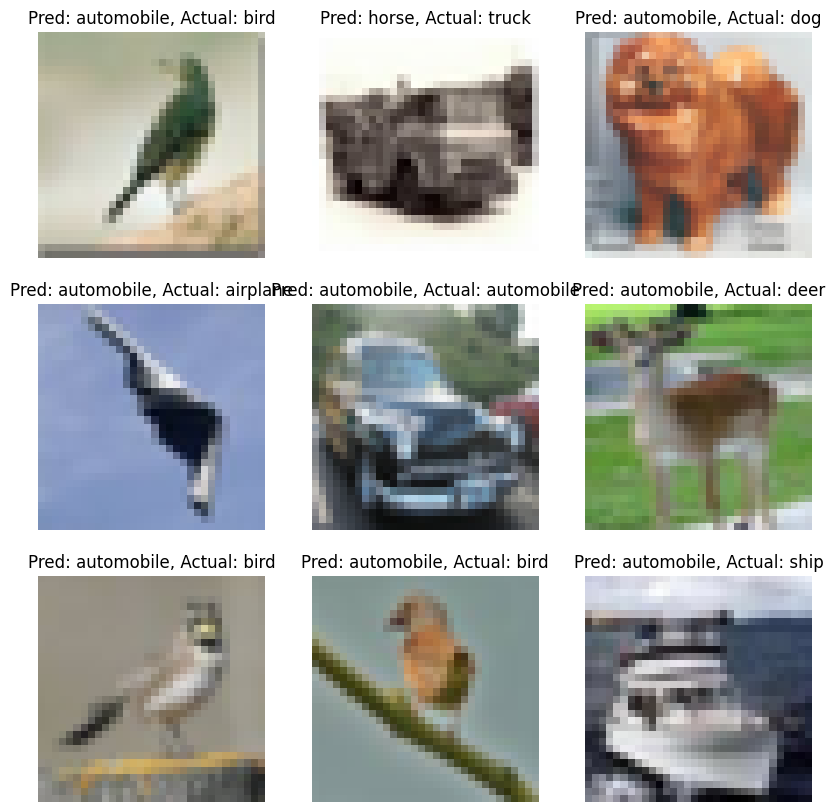

In [63]:
random_predictions()

In [64]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [65]:
def train_pass(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer) -> torch.Tensor:
    model.train()
    train_loss = 0
    for batch,(X,y) in enumerate(dataloader):
        y_preds = model(X)
        loss = loss_fn(y_preds,y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/len(dataloader)
    return train_loss

In [70]:
def test_pass(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module) -> torch.Tensor:
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            test_loss += loss
            test_acc += accuracy_fn(y,y_pred.argmax(dim=1))
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    return test_loss, test_acc

In [67]:
def train_test_loop(model: torch.nn.Module,
                    train_dataloader: torch.utils.data.DataLoader,
                    test_dataloader: torch.utils.data.DataLoader,
                    epochs: int,
                    loss_fn: torch.nn.Module,
                    optimizer: torch.optim.Optimizer):
    for epoch in range(epochs):
        train_loss = train_pass(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_pass(model, test_dataloader, loss_fn)
        print(f"Epoch: {epoch+1}/{epochs}\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f} Test accuracy: {test_acc:.2f}%")

In [68]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),lr=0.01)

In [71]:
train_test_loop(model1, train_dataloader, test_dataloader, 20, loss_fn, optimizer)

Epoch: 1/20
Train loss: 1.88985 | Test loss: 1.75783 Test accuracy: 37.29%
Epoch: 2/20
Train loss: 1.71962 | Test loss: 1.75584 Test accuracy: 37.49%
Epoch: 3/20
Train loss: 1.58423 | Test loss: 1.68813 Test accuracy: 41.12%
Epoch: 4/20
Train loss: 1.44126 | Test loss: 1.37851 Test accuracy: 50.84%
Epoch: 5/20
Train loss: 1.34124 | Test loss: 1.34198 Test accuracy: 52.95%
Epoch: 6/20
Train loss: 1.27097 | Test loss: 1.25103 Test accuracy: 56.14%
Epoch: 7/20
Train loss: 1.21232 | Test loss: 1.25291 Test accuracy: 55.51%
Epoch: 8/20
Train loss: 1.17430 | Test loss: 1.21248 Test accuracy: 57.66%
Epoch: 9/20
Train loss: 1.13879 | Test loss: 1.19857 Test accuracy: 58.03%
Epoch: 10/20
Train loss: 1.10440 | Test loss: 1.21368 Test accuracy: 57.60%
Epoch: 11/20
Train loss: 1.08276 | Test loss: 1.16554 Test accuracy: 59.30%
Epoch: 12/20
Train loss: 1.05936 | Test loss: 1.18264 Test accuracy: 58.86%
Epoch: 13/20
Train loss: 1.04100 | Test loss: 1.19559 Test accuracy: 57.93%
Epoch: 14/20
Train lo

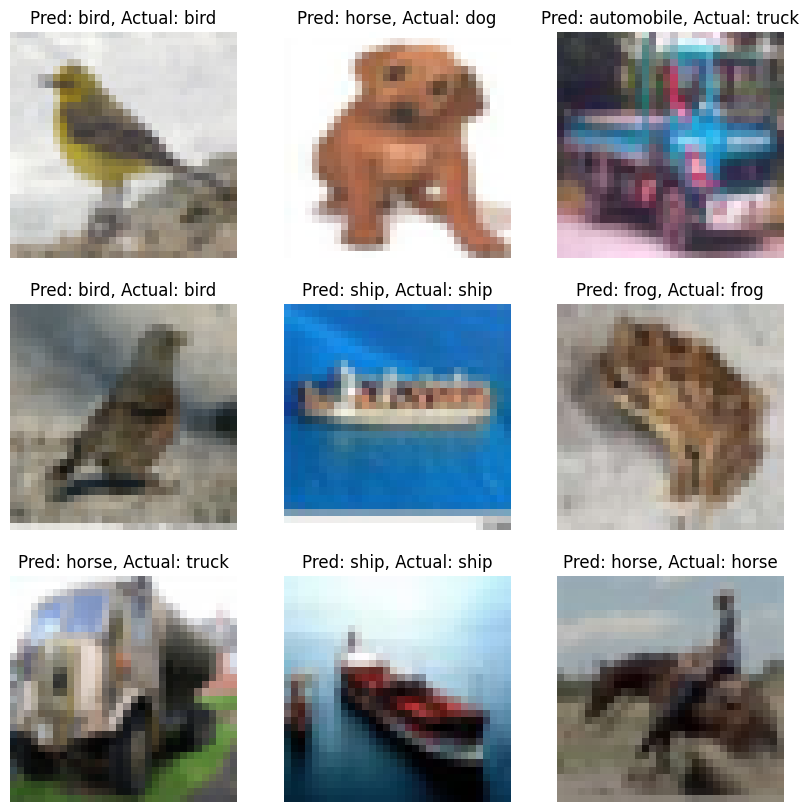

In [72]:
random_predictions()